<a href="https://colab.research.google.com/github/davidogm/DataScience/blob/main/datamining%20/EjemplosClustering/k_means_cancer_gene_expression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# K-Means Clustering in Python -- TCGA Cancer Gene Expression

This jupyter notebook accompanies the Real Python's [Practical K-Means Clustering in Python](https://realpython.com/practical-k-means-clustering-python/) article. Specifically, this notebook works through the **second half** of the article, from where the TCGA cancer gene expression dataset is introduced.

## Building a K-Means Clustering Pipeline

In [1]:
import tarfile
import urllib

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, MinMaxScaler

Se carga directamente desde uci

In [2]:
uci_tcga_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/00401/"
)
archive_name = "TCGA-PANCAN-HiSeq-801x20531.tar.gz"

# build the url
full_download_url = urllib.parse.urljoin(uci_tcga_url, archive_name)

# download the file
r = urllib.request.urlretrieve(full_download_url, archive_name)

# extract the data from the archive
tar = tarfile.open(archive_name, "r:gz")
tar.extractall()
tar.close()

In [3]:
datafile = "TCGA-PANCAN-HiSeq-801x20531/data.csv"
labels_file = "TCGA-PANCAN-HiSeq-801x20531/labels.csv"

data = np.genfromtxt(
    datafile, delimiter=",", usecols=range(1, 20532), skip_header=1
)

true_label_names = np.genfromtxt(
    labels_file, delimiter=",", usecols=(1,), skip_header=1, dtype=str
)

In [4]:
data.shape

(801, 20531)

In [5]:
data[:3, :5]

array([[ 0.        ,  2.01720929,  3.26552691,  5.47848651, 10.43199896],
       [ 0.        ,  0.59273209,  1.58842082,  7.58615674,  9.62301086],
       [ 0.        ,  3.51175898,  4.32719872,  6.88178696,  9.87072997]])

In [6]:
true_label_names[:5]

array(['PRAD', 'LUAD', 'PRAD', 'PRAD', 'BRCA'], dtype='<U4')

Lo cargo en pandas también por hacer clasificación de tipo de datos

In [10]:
!ls

sample_data  TCGA-PANCAN-HiSeq-801x20531  TCGA-PANCAN-HiSeq-801x20531.tar.gz


In [7]:
import pandas as pd

labelsCancer=pd.read_csv('/content/TCGA-PANCAN-HiSeq-801x20531/labels.csv')


In [8]:
labelsCancer.Class.unique()

array(['PRAD', 'LUAD', 'BRCA', 'KIRC', 'COAD'], dtype=object)

In [9]:
labelsCancer.groupby('Class').count()

,Unnamed: 0
Class,
BRCA,300
COAD,78
KIRC,146
LUAD,141
PRAD,136


--- Fin de pruebas

In [11]:
label_encoder = LabelEncoder()

In [12]:
true_labels = label_encoder.fit_transform(true_label_names)

In [13]:
true_labels[:5]

array([4, 3, 4, 4, 0])

In [14]:
label_encoder.classes_

array(['BRCA', 'COAD', 'KIRC', 'LUAD', 'PRAD'], dtype='<U4')

In [16]:
n_clusters = len(label_encoder.classes_)
n_clusters

5

In [17]:
preprocessor = Pipeline(
    [
        ("scaler", MinMaxScaler()),
        ("pca", PCA(n_components=2, random_state=42)),
    ]
)

In [18]:
clusterer = Pipeline(
    [
        (
            "kmeans",
            KMeans(
                n_clusters=n_clusters,
                init="k-means++",
                n_init=50,
                max_iter=500,
                random_state=42,
            ),
        ),
    ]
)

In [19]:
pipe = Pipeline([("preprocessor", preprocessor), ("clusterer", clusterer)])

In [20]:
pipe.fit(data)

Pipeline(steps=[('preprocessor',
                 Pipeline(steps=[('scaler', MinMaxScaler()),
                                 ('pca',
                                  PCA(n_components=2, random_state=42))])),
                ('clusterer',
                 Pipeline(steps=[('kmeans',
                                  KMeans(max_iter=500, n_clusters=5, n_init=50,
                                         random_state=42))]))])

In [21]:
preprocessed_data = pipe["preprocessor"].transform(data)

In [22]:
predicted_labels = pipe["clusterer"]["kmeans"].labels_

In [23]:
silhouette_score(preprocessed_data, predicted_labels)

0.5118775528450281

In [24]:
adjusted_rand_score(true_labels, predicted_labels)

0.722276752060253

In [25]:
pcadf = pd.DataFrame(
    pipe["preprocessor"].transform(data),
    columns=["component_1", "component_2"],
)

pcadf["predicted_cluster"] = pipe["clusterer"]["kmeans"].labels_
pcadf["true_label"] = label_encoder.inverse_transform(true_labels)

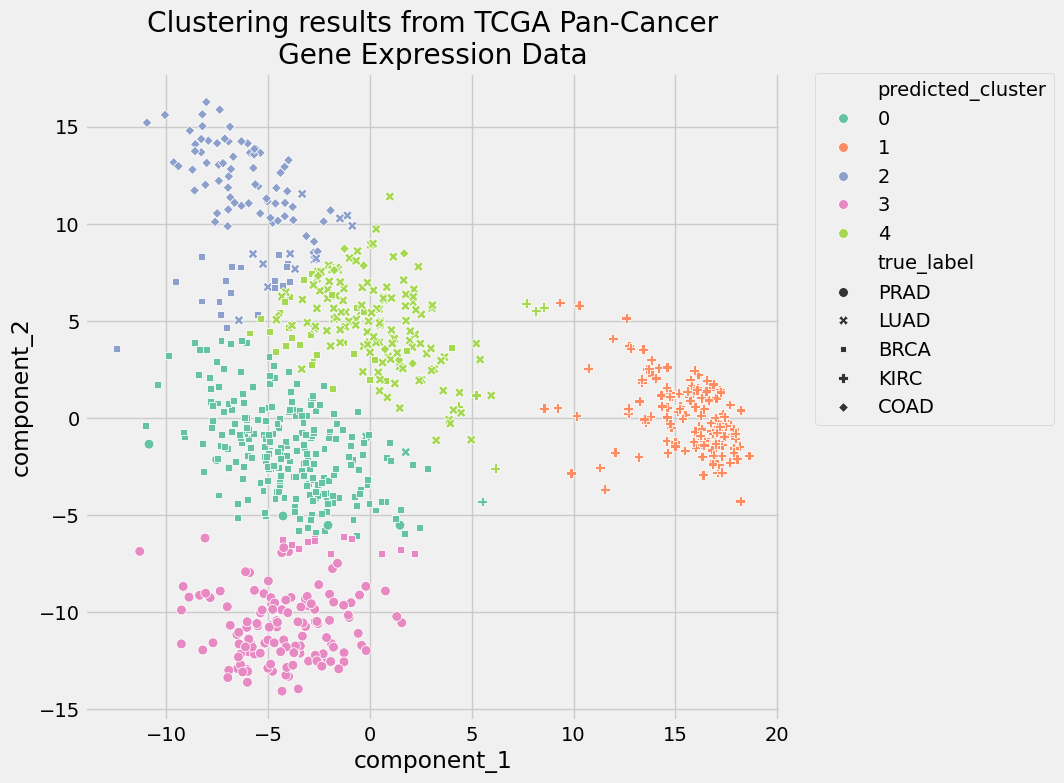

In [26]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(8, 8))

scat = sns.scatterplot(
x="component_1",
y="component_2",
s=50,
data=pcadf,
hue="predicted_cluster",
style="true_label",
palette="Set2",
)

scat.set_title("Clustering results from TCGA Pan-Cancer\nGene Expression Data")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

plt.show()

## Tuning a K-Means Clustering Pipeline

In [27]:
# Empty lists to hold evaluation metrics
silhouette_scores = []
ari_scores = []
for n in range(2, 11):
    # This set the number of components for pca,
    # but leaves other steps unchanged
    pipe["preprocessor"]["pca"].n_components = n
    pipe.fit(data)

    silhouette_coef = silhouette_score(
        pipe["preprocessor"].transform(data),
        pipe["clusterer"]["kmeans"].labels_,
    )
    ari = adjusted_rand_score(
        true_labels,
        pipe["clusterer"]["kmeans"].labels_,
    )

    # Add metrics to their lists
    silhouette_scores.append(silhouette_coef)
    ari_scores.append(ari)

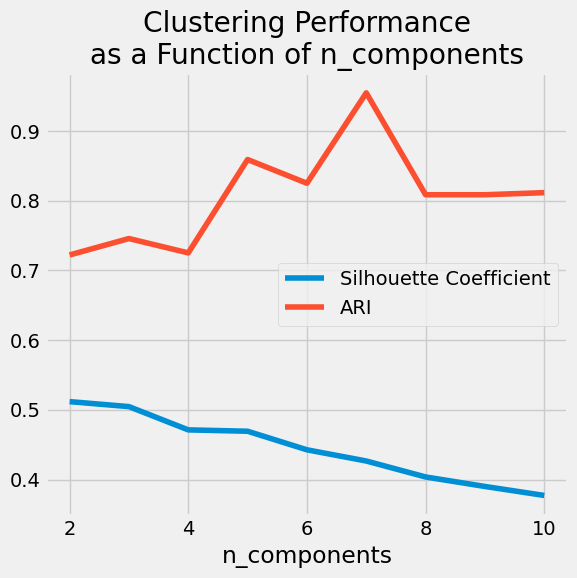

In [28]:
plt.style.use("fivethirtyeight")
plt.figure(figsize=(6, 6))
plt.plot(
    range(2, 11),
    silhouette_scores,
    c="#008fd5",
    label="Silhouette Coefficient",
)
plt.plot(range(2, 11), ari_scores, c="#fc4f30", label="ARI")

plt.xlabel("n_components")
plt.legend()
plt.title("Clustering Performance\nas a Function of n_components")
plt.tight_layout()
plt.show()